# Implementing DistilBERT

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import torch as tc
import transformers as tns
import tensorflow as tf
import textblob as tb
import regex as re
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression

_wordnet = nltk.corpus.wordnet

## Read Data

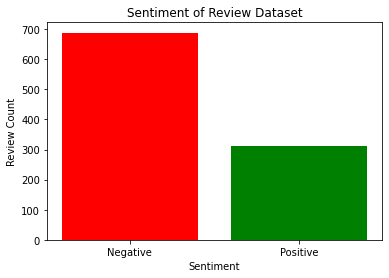

In [2]:
# Uncomment for sample of 100 reviews
# sourcefile = 'Data/review_100.json'

# Uncomment for sample of 1,000 reviews
sourcefile = 'Data/review_1000.json'

# Uncomment for sample of 10,000 reviews
# sourcefile = 'Data/review_10000.json'

# Load into DataFrame
data = pd.read_json(sourcefile, lines=True)

# Add Sentiment Column and Restructure DataFrame
data['Sentiment'] = data['stars'].apply(lambda score: "Positive" if score > 3 else "Negative")
data.rename(columns={'text':'Review', 'stars':'Rating'}, inplace=True)
data = data[['Review', 'Rating', 'Sentiment']]

# Display the sentiment distribution
plt.bar(data.Sentiment.unique(), data.Sentiment.value_counts(), color = ['red', 'green'])
plt.title('Sentiment of Review Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Review Count')

# Convert 'Positive' or 'Negative' to 1 or 0
data['Sentiment'] = data['Sentiment'].apply(lambda score: 1 if score == 'Positive' else 0)

In [3]:
data.sample(10)

,Review,Rating,Sentiment
454,"Great place for a drink, nice friendly staff. ...",4,1
928,"First time visit the other day, amazing!!!! Be...",5,1
328,So worth the wait! The crepes are amazing! I a...,5,1
782,We arrived a few minutes early for a 7pm reser...,1,0
873,Had not been for years.\n\nWe went for lunch. ...,2,0
307,The Shop is an amazing space! Their attention ...,5,1
557,Stayed for one week post Christmas. Unless you...,2,0
259,A good place to order from when its late and y...,3,0
630,This is one of my favorite bead stores in Nash...,5,1
526,After a long hiatus from reviewing I have awak...,5,1


## Preprocessing

In [4]:
# Preprocessing methods

def preprocess(review):
    cleaned = []
    review = re.sub(r'&amp;', '&', review)
    review = re.sub(r'\s+', ' ', review).strip()
    for word in review.split():
        cleaned.append(lemmatize(word))
    return ' '.join(cleaned)

def lemmatize(word):
    word = tb.Word(word).lemmatize()
    word = tb.Word(word).lemmatize(_wordnet.VERB)
    word = tb.Word(word).lemmatize(_wordnet.ADJ)
    word = tb.Word(word).lemmatize(_wordnet.ADV)
    return word

In [5]:
# Assign cleaned-up reviews to DataFrame

data['Review'] = data.apply(lambda row: preprocess(row['Review']), axis=1)

## Model Creation and Tuning

In [6]:
# Instantiate tokenizer and model

tokenizer = tns.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = tns.DistilBertModel.from_pretrained('distilbert-base-uncased', dropout=0.5)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
# Encode the reviews into token embeddings

tokenized = data['Review'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, padding='max_length', truncation=True, max_length=512))

In [8]:
# Display sample of the tokenized values

tokenized.sample(5)

26     [101, 2190, 7273, 2833, 1999, 1996, 2181, 1012...
885    [101, 2023, 2022, 2673, 1045, 2215, 1999, 2202...
910    [101, 1996, 14380, 9850, 2022, 1037, 2204, 103...
748    [101, 2429, 2000, 2026, 3325, 1010, 2045, 2022...
973    [101, 4310, 2022, 2200, 2658, 1998, 1010, 2918...
Name: Review, dtype: object

In [9]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

## Model Training

In [10]:
# Model training may take a long time

input_ids = tc.tensor(tokenized)
attention_mask = tc.tensor(attention_mask)

with tc.no_grad():
    model_output = model(input_ids, attention_mask=attention_mask)

## Model Performance Test

In [11]:
# Obtain test sets and labels

features = model_output[0][:,0,:].numpy()
labels = data['Sentiment']

train_features, test_features, train_labels, test_labels = tts(features, labels)

In [12]:
lr_clf = LogisticRegression(max_iter=500)
lr_clf.fit(train_features, train_labels)

LogisticRegression(max_iter=500)

## Model Accuracy Check

In [13]:
# Displays the accuracy of the model

lr_clf.score(test_features, test_labels)

0.836

In [14]:
model.save_pretrained('./sentiment')